In [ ]:
!pip install -qq transformers


In [ ]:
pip install transformers==3

In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.5
torch 1.7.0+cu101
transformers 3.0.0


In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
## Dataser has been open sourced and is available publicly at this link

!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 41.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.0MB/s]


In [ ]:
df = pd.read_csv('reviews.csv') #### Contents all we need, i.e. it has the review and the score

In [ ]:
df1 = pd.read_csv('apps.csv')

In [ ]:
df.columns

Index(['userName', 'userImage', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'sortOrder',
       'appId'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


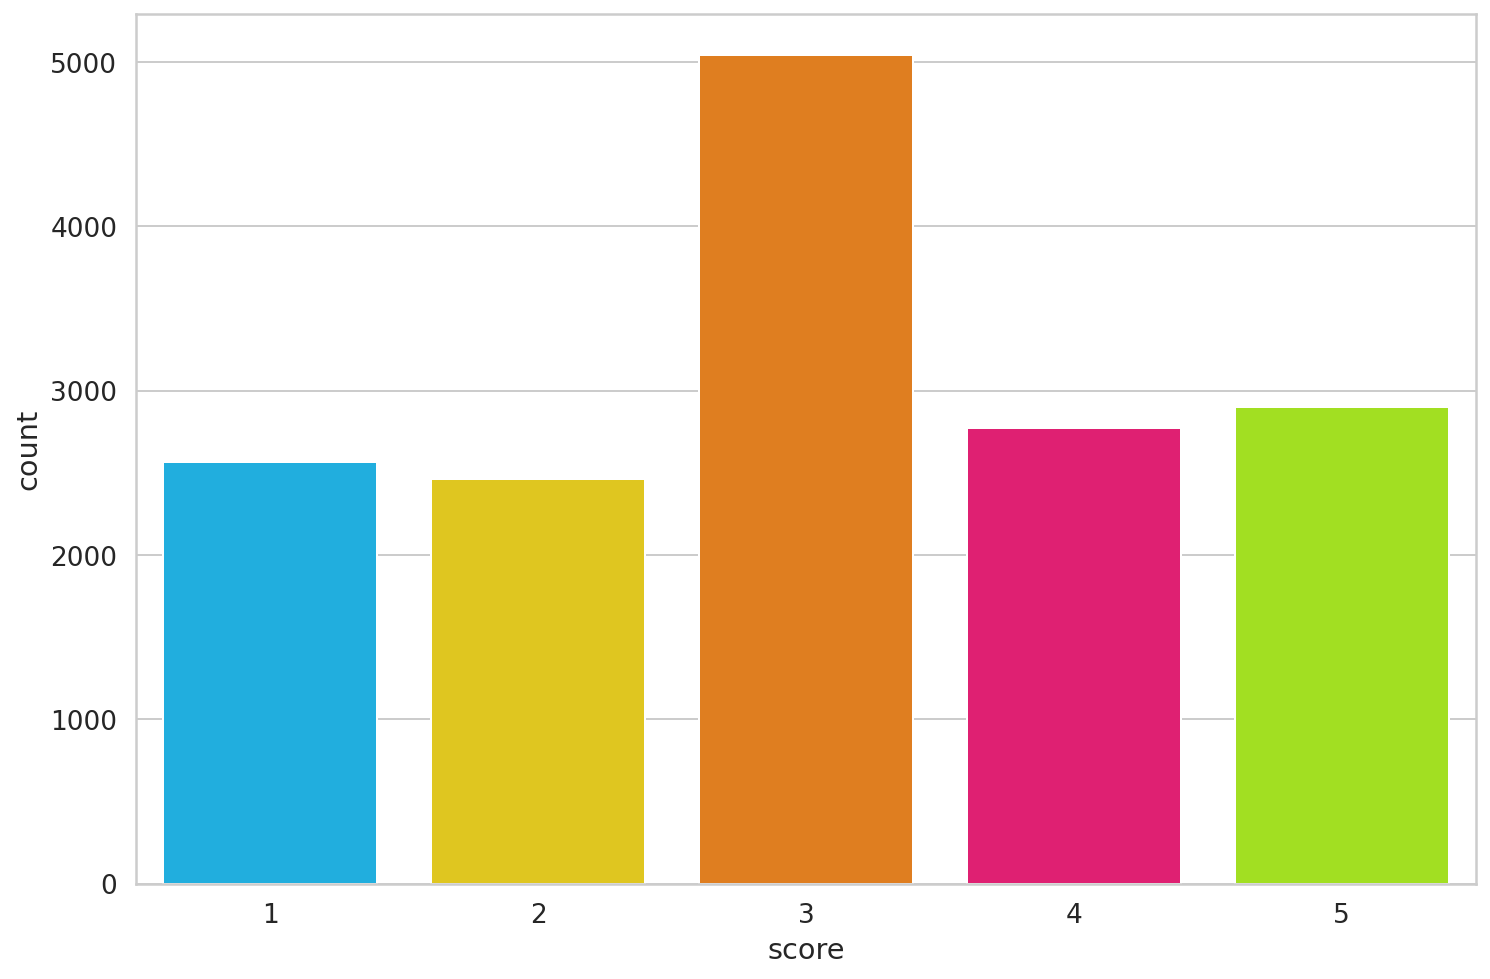

In [ ]:
sns.countplot(df['score'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


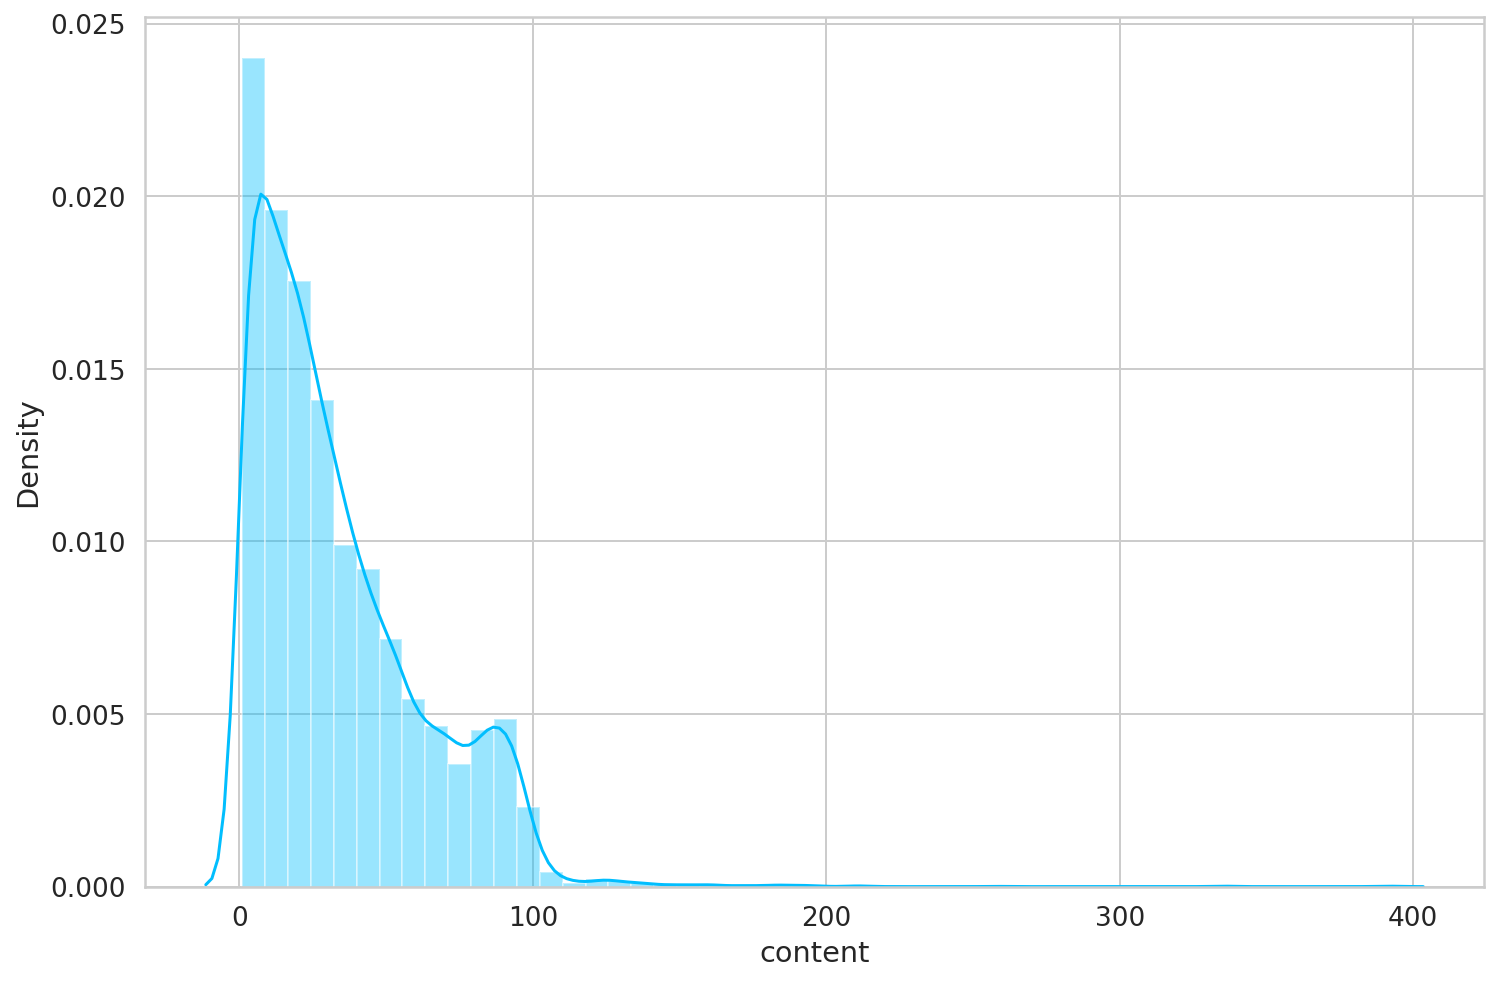

In [ ]:
sns.distplot((df['content'].apply(lambda x: len(x.split(' ')))))

In [ ]:
##

Now we convert the score into three categories

In [ ]:
def make_classes(x):

  if x < 3:
    return 0 ## class negative

  if x == 3:
    return 1 #### class neutral
  
  if x>3:
    return 2 ### class positive

In [ ]:
### categorizing targets

df['targets'] = df['score'].apply(make_classes)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

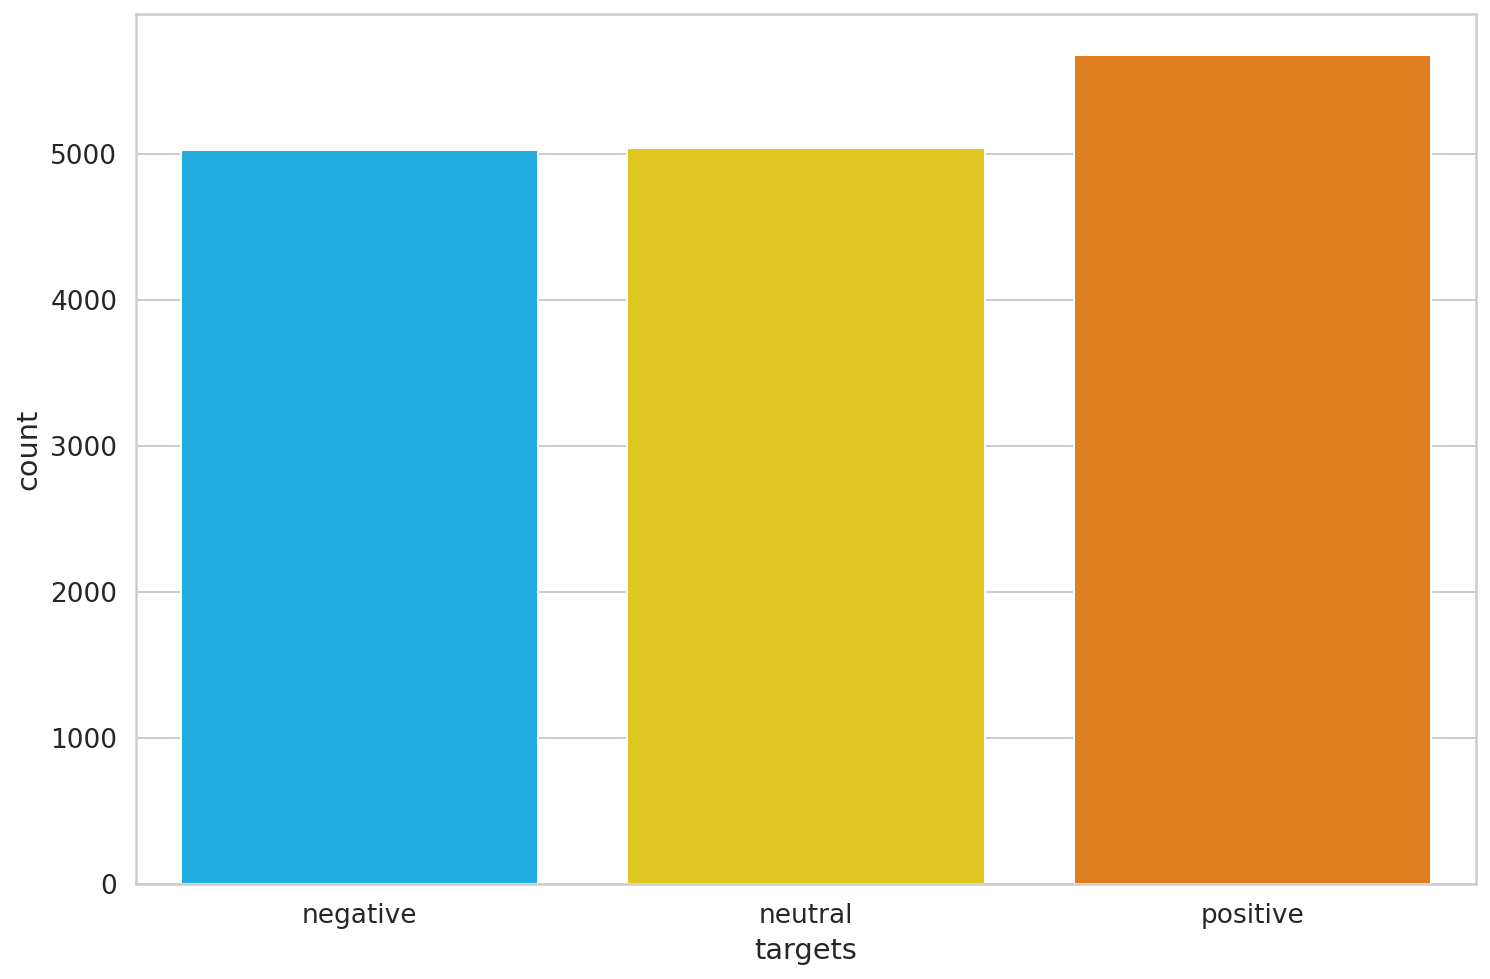

In [ ]:
ax = sns.countplot(df['targets'])

ax.set_xticklabels(['negative', 'neutral', 'positive'])

In [ ]:
#### As suggested in the HugginFace Library, we perform all the pre processing 
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
text = "The biggest thing that I thought would happen was the fact that It will always go uphill" ## Sentence doesnt make too much sense lol:)

In [ ]:
sample_tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(sample_tokens)

In [ ]:
tokenizer.sep_token_id

102

In [ ]:
encoding = tokenizer.encode_plus(
  text,
  max_length=32,
  add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,  ## This needs to be given as input to the Bert LM
  return_tensors='pt',        # Return PyTorch tensors
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


In [ ]:
encoding['input_ids']

tensor([[ 101, 1109, 4583, 1645, 1115,  146, 1354, 1156, 3333, 1108, 1103, 1864,
         1115, 1135, 1209, 1579, 1301, 1146, 6690,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

Creating a Dataset in PyTorch

In [ ]:
class AppReview(Dataset):

  def __init__(self, review, target, MAX_LEN, tokenizer):

    self.review = review
    self.target = target
    self.max_len = MAX_LEN
    self.tokenizer = tokenizer

  def __len__(self):

    return len(self.target)

  def __getitem__(self, item):

    #### This function returns a dictionary when the dataset class is called
    review = str(self.review[item])
    target = self.target[item]

    encoding = self.tokenizer.encode_plus(
        review,
        max_length= self.max_len,
        add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,  ## This needs to be given as input to the Bert LM
        return_tensors='pt',
        truncation  = True
        
    )

    return {
        'review': review,
        'target': target,
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask']
    }



In [ ]:
reviews = df.content.to_numpy()

In [ ]:
targets = df.targets.to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews, targets, test_size = 0.11, random_state = 101 ) 

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.4, random_state = 101 )

In [ ]:
##### We have the train, validation and test set for our analysis

In [ ]:
data = AppReview(X_train, y_train, 160, tokenizer)

In [ ]:
def create_data_loader(X, y, tokenizer, MAX_LEN):

  data = AppReview(
      X, y, MAX_LEN, tokenizer
  )

  return DataLoader(
      data,
      batch_size = 16,
      num_workers = 4
  )

In [ ]:
loader = create_data_loader(X_train, y_train, tokenizer, 160)

In [ ]:
 a = next(iter(loader))

In [ ]:
train_data_loader = create_data_loader(X_train, y_train, tokenizer, 160)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, 160)
validation_data_loader = create_data_loader(X_val, y_val, tokenizer, 160)

Building the Sentiment CLassifier

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors = 'pt',  # Return PyTorch tensors
)

encoding.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self,n_classes):
    super(SentimentClassifier, self).__init__()
    self.Bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.dropout = nn.Dropout(p = 0.2)
    self.linear = nn.Linear(self.Bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.Bert(
        input_ids = input_ids,
        attention_mask = attention_mask                        ##### Note: while using the BertModel: remember to use return_dict = False
    )

    x = self.dropout(pooled_output)
    out = self.linear(x)

    return out

In [ ]:
model = SentimentClassifier(3).to(device)

In [ ]:
input_ids = data['input_ids'].squeeze(1)
att_mask = data['attention_mask'].squeeze(1)
targets = data['target']

In [ ]:
print(input_ids.shape)

torch.Size([64, 160])


In [ ]:
F.softmax(model(input_ids, att_mask), dim=1)

tensor([[0.2719, 0.4067, 0.3214],
        [0.3613, 0.2704, 0.3683],
        [0.2892, 0.3089, 0.4019],
        [0.3040, 0.3105, 0.3855],
        [0.2455, 0.4968, 0.2577],
        [0.3274, 0.3443, 0.3283],
        [0.3151, 0.2809, 0.4039],
        [0.1757, 0.4275, 0.3968],
        [0.2479, 0.4551, 0.2970],
        [0.2950, 0.3229, 0.3821],
        [0.2981, 0.2336, 0.4683],
        [0.2357, 0.4125, 0.3519],
        [0.2840, 0.2535, 0.4625],
        [0.3797, 0.3575, 0.2628],
        [0.3220, 0.2756, 0.4024],
        [0.2722, 0.4072, 0.3205]], grad_fn=<SoftmaxBackward>)

Model Training

In [ ]:
EPOCHS = 12

optimizer = AdamW(model.parameters(), lr = 1e-5, correct_bias= True)
total_steps = len(train_data_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, optimizer, criterion, scheduler, data_loader, device, num_examples):

  """
  This function runs one training epoch including forward prop and backprop

  """

  model = model.train() ## setting model in training model

  losses = []
  correct_predictions = 0

  for data_batch in data_loader:

    input_ids = data_batch['input_ids'].squeeze(1).to(device)
    attention_mask = data_batch['attention_mask'].squeeze(1).to(device)

    target = data_batch['target'].to(device)

    output = model(
        input_ids,
        attention_mask
    )
 
    loss = criterion(output, target) ## we evaluate the loss at each step
    losses.append(loss.item())

    _, predictions = torch.max(output, dim = 1)
    correct_predictions += torch.sum(predictions == target)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


  return (correct_predictions / num_examples, np.mean(losses))


In [ ]:
def evaluate_model( model, optimizer, criterion, scheduler, data_loader, num_examples):

  """
  This function is essentially used to evaluate the model with validation or test set

  """

  correct_predictions = 0
  losses = []
  model.eval()

  with torch.no_grad():
    for data_batch in data_loader:

      input_ids = data_batch['input_ids'].squeeze(1).to(device)
      attention_mask = data_batch['attention_mask'].squeeze(1).to(device)

      target = data_batch['target'].to(device)

      output = model(
          input_ids,
          attention_mask
      )

      _, predictions = torch.max(output, dim = 1 )
      correct_predictions += torch.sum(predictions == target)

      loss = criterion(output, target) ## we evaluate the loss at each step
      losses.append(loss.item())


  return (correct_predictions / num_examples, np.mean(losses))



In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, optimizer, 
                                      criterion, scheduler, train_data_loader,
                                      device, len(X_train))
  print(f'Train loss: {train_loss} Train accuracy: {train_acc}')

  #print("////")

  val_acc , val_loss = evaluate_model(model, optimizer, criterion, scheduler, validation_data_loader, len(X_val))

  print(f'Validation loss: {val_loss} Validation accuracy: {val_acc}')

  
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


Epoch 1/12
----------
Train loss: 0.5565670839506606 Train accuracy: 0.7702134251594543
Validation loss: 0.5779601382938299 Validation accuracy: 0.7636887431144714
Epoch 2/12
----------
Train loss: 0.37999975345773646 Train accuracy: 0.8581317663192749
Validation loss: 0.5647208360447125 Validation accuracy: 0.7982708811759949
Epoch 3/12
----------
Train loss: 0.2643333546956576 Train accuracy: 0.9129379987716675
Validation loss: 0.6209365923634984 Validation accuracy: 0.8299711346626282
Epoch 4/12
----------
Train loss: 0.2030786141784028 Train accuracy: 0.9361307621002197
Validation loss: 0.7274653859097849 Validation accuracy: 0.8242074847221375
Epoch 5/12
----------
Train loss: 0.15139926017206756 Train accuracy: 0.9536145329475403
Validation loss: 0.7860427683388646 Validation accuracy: 0.8443803787231445
Epoch 6/12
----------
Train loss: 0.12827851419815778 Train accuracy: 0.9629629850387573
Validation loss: 0.8036206008189104 Validation accuracy: 0.85014408826828
Epoch 7/12
----

In [ ]:
history['val_acc']

[tensor(0.7637, device='cuda:0'),
 tensor(0.7983, device='cuda:0'),
 tensor(0.8300, device='cuda:0'),
 tensor(0.8242, device='cuda:0'),
 tensor(0.8444, device='cuda:0'),
 tensor(0.8501, device='cuda:0'),
 tensor(0.8444, device='cuda:0'),
 tensor(0.8573, device='cuda:0'),
 tensor(0.8516, device='cuda:0'),
 tensor(0.8545, device='cuda:0'),
 tensor(0.8588, device='cuda:0'),
 tensor(0.8588, device='cuda:0'),
 tensor(0.8588, device='cuda:0'),
 tensor(0.8588, device='cuda:0'),
 tensor(0.8588, device='cuda:0')]

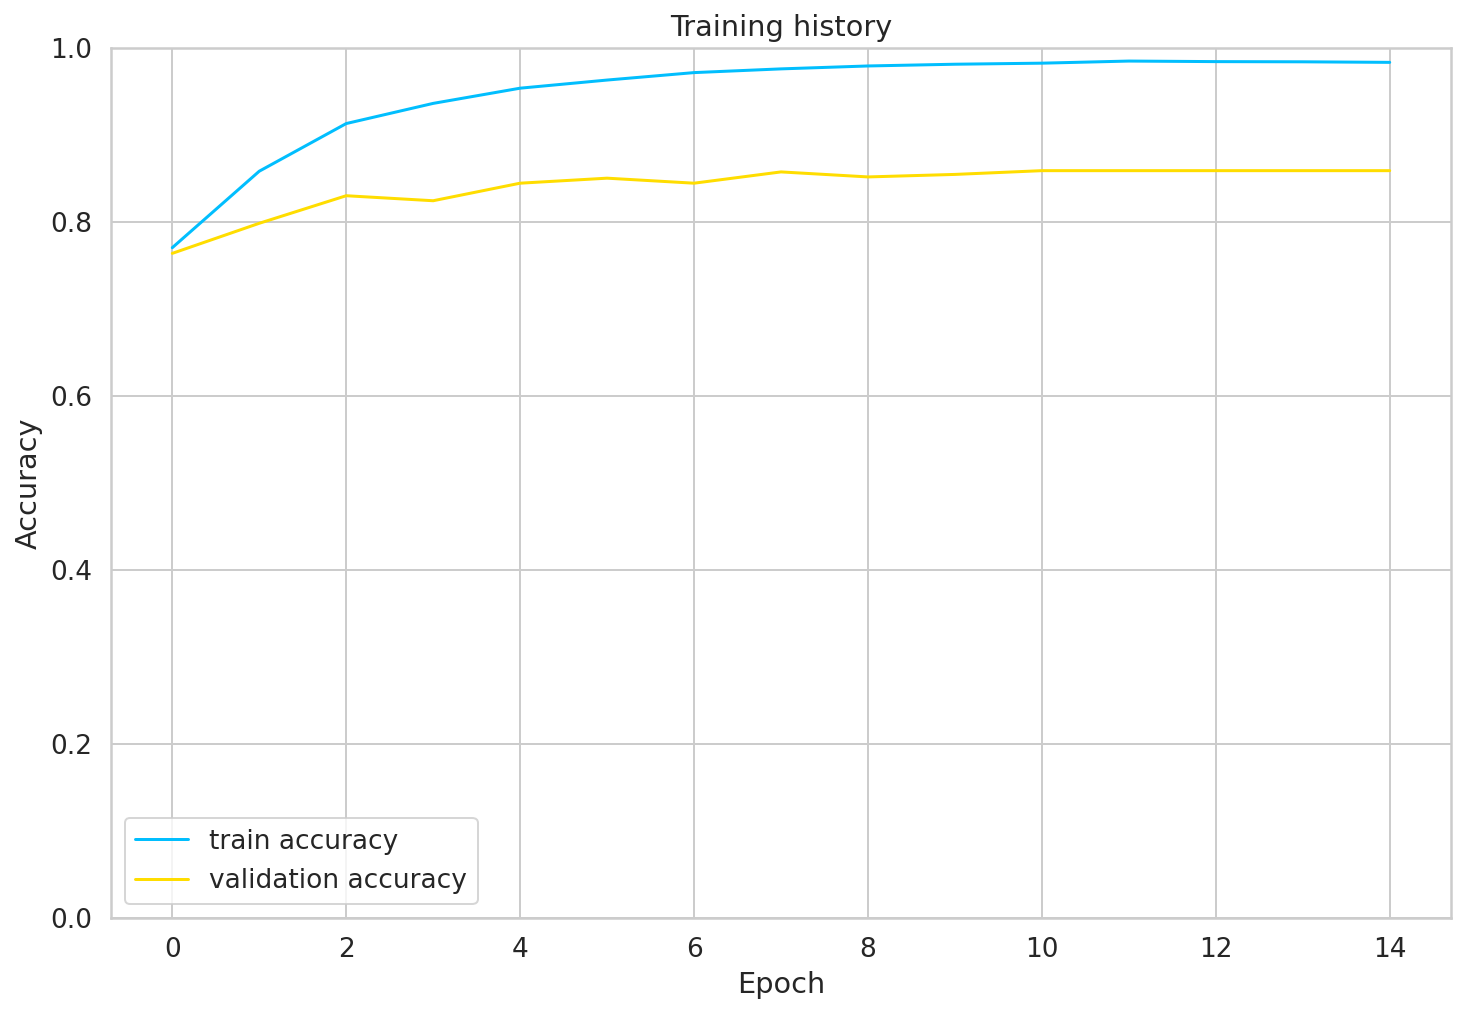

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = evaluate_model(model, optimizer, criterion, scheduler, test_data_loader, len(X_test))


In [ ]:
test_acc

tensor(0.8653, device='cuda:0')

In [ ]:
def get_predictions(model, data_loader):

  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d["review"]
      input_ids = d["input_ids"].squeeze(1).to(device)
      attention_mask = d["attention_mask"].squeeze(1).to(device)
      targets = d["target"].to(device)

      outputs = model(
        input_ids,
        attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values



In [ ]:
text, predictions, pred_probs, targets = get_predictions(model, test_data_loader)

In [ ]:
"""
This can be used to see the example and how our model predicts

"""

x = 460

print(text[x])
print(predictions[x].item())
print(targets[x].item())
print(pred_probs[x])

Used to love this app, but the new widget is ugly, unreadable, and too easy to accidentally check something. I'll be looking for a replacement if this hasn't been fixed by the time my subscription runs out.
1
1
tensor([6.0023e-05, 9.9967e-01, 2.6854e-04])


1039